## Gradating gene expression across 88 genes

Experimental overview:  Gene expression of 88 genes was gradated in E. coli using CRISPRi.  The growth assay was performed in the turbiodstat at 37 C in M9 minimal media + glucose (0.4%) or glycerol (0.2%).  Time points were taken every two hours after complete ATc induction of CRISPRi machinery. Relative growth effects were calculated by linearly fitting a change in relative sgRNA frequency over time.

### NGS counting prior to this analysis

The number of occurences for each sgRNA in the NGS data was counted prior to this analysis using the following workflow.

1. Combine paired-end reads using usearch.
2. Count occurences of each sgRNA in .fastq files using 200114-Count_main.py and Count_sgRNA_ADM_200114.py.  Here a Q30 filter was applied to the 20N sgRNA homology region to ensure high quality identifications.  Counting was performed using the BioHPC super computing cluster at UT Southwestern.
3.  The counts for each sgRNA across each timepoint and media condition are processed in this notebook into normalized growth rates.

### This notebook can analyze glucose and/or glycerol data.

Conclusions:  
1. CRISPRi can cause growth defects across a broad range in M9-glucose and M9-glycerol.
2. Sequencing data is of high quality and replicates correlate well with each other.
3. The growth effect of targeting a single gene with CRISPRi can vary based on guide selection and design.

Andrew Mathis. Edited by Kimberly Reynolds and Ryan Otto.

Last updated 8/17/20

## Import useful libraries

In [1]:
import glob # Moving data
import pickle # Moving data
import re # Search function
import pandas as pd # Data organization
import numpy as np # Data organization
from scipy import stats # For linear regression and sem calculations
import matplotlib as mpl # Plotting funciton
import matplotlib.pyplot as plt # Plotting function
from matplotlib.colors import LogNorm # Color bar log scaling
from matplotlib.lines import Line2D # Custom legend creation
# Renders figures in notebook
%matplotlib inline

## Establish all paths and variables unique to this analysis.

Default values to recreate figures are provided.

In [2]:
# Establish file paths
sgRNA_path = 'inputs/20191111_sgRNA_lib.fasta' # Path to sgRNA sequence and ID information
counts_path = 'inputs/counts/' # General path to count data from the main turbidostat run
miSeq_path = 'inputs/miSeq_raw_counts.pickle' # Path to library counts data from a sequencing data
turb_path = 'inputs/20200203_turb_growth.pickle' # Path to culture growth rate information
design_path = 'inputs/20200207_selected_genes_chem.csv' # Path to gene characteristics information
pickle_path = 'pickle/' # General path for all intermediate data frames saved as *.pickle
output_path = 'outputs/' # General path for output data saved as .csv
figure_path = 'Figures/' # General path for saving figures
table_path = 'Tables/' # General path for saving tables

# Designate DNA barcodes for replicate measurements and time (in hours) of collection for each timepoint.
# Time = 0 is three hours after ATc addition
BC_lib = ['CTTTCA', 'ATCATG', 'GCATGG', 'GTATGA', 'AGTCTA', 'CCTAGT']

# Establish a list of medias to analyze ('Glu' and/or 'Gly') -- these correspond to M9+Glucose and M9+Glycerol
medias = ['Glu', 'Gly']

# List of columns to use to sort growth data in reorder() and frequency_check()
sort_by = ['mean', 'sem', 'std', 'reps'] 

# Sequencing data timepoints
# Note: No 8 hour timepoint was taken in either media condition, and two glycerol timepoints (4 and 12 hours)
# were excluded to allow for sufficient sequencing depth
TPs = {}
TPs['Glu'] = np.array([0, 2, 4, 6, 10, 12, 14])
TPs['Gly'] = np.array([0, 2, 6, 10, 14])

# Keys in turbidostat growth data for each media condition
turb_lib = {}
turb_lib['Glu'] = 'Glu-lib-1'
turb_lib['Gly'] = 'Gly-lib-2'

# Example escaper for each media condition
escaper_dict = {}
escaper_dict['Glu'] = 'ribF_1_33_C'
escaper_dict['Gly'] = 'gpmM_3_201_C'

# sgRNA that causes near death effects on growth to use for normalization
death_norm = 'gyrB_2_101_C' # Based on previous work

# Date stamp for output files
date = '20200923'

# Organized list of sgRNA names, sorted by parent guide, mismatch style, and number of mismatches
new_cols = ['1_C_C', '1_W_MM1', '1_B_MM2', '1_B_MM3', '1_B_MM4', '1_B_MM5', '1_B_MM6', '1_B_MM7', '1_B_MM8', 
            '1_B_MM9', '1_B_MM10', '1_B_MM11', '1_B_MM12', '1_B_MM13', '1_B_MM14', '1_W_MM2', '1_W_MM3', '1_W_MM4', 
            '1_W_MM5', '1_W_MM6', '1_W_MM7', '1_W_MM8', '1_W_MM9', '1_W_MM10', '1_W_MM11', '1_W_MM13', '1_W_MM16', 
            '1_W_MM19', '1_W_MM20', '1_D_MM2-8', '1_D_MM3-10', '1_D_MM4-6', '1_D_MM7-9', '1_D_MM9-19', '2_C_C', 
            '3_C_C', '3_W_MM1', '3_B_MM2', '3_B_MM3', '3_B_MM4', '3_B_MM5', '3_B_MM6', '3_B_MM7', '3_B_MM8', 
            '3_B_MM9', '3_B_MM10', '3_B_MM11', '3_B_MM12', '3_B_MM13', '3_B_MM14', '3_W_MM2', '3_W_MM3', '3_W_MM4', 
            '3_W_MM5', '3_W_MM6', '3_W_MM7', '3_W_MM8', '3_W_MM9', '3_W_MM10', '3_W_MM11', '3_W_MM13', '3_W_MM16', 
            '3_W_MM19', '3_W_MM20', '3_D_MM2-8', '3_D_MM3-10', '3_D_MM4-6', '3_D_MM7-9', '3_D_MM9-19']


#### sgRNA naming convention: 

1\_\*\_\* is first guide in gene (closest to 5 prime end), 2\_\*\_\* is second (control guide, as close as possible to guide 1), and 3\_\*\_\* is at least 200bp from 5 prime end. 

\*\_C\_C is the on target guide (no mismatches)

\*\_B\_* refers to Bikard-style (compounding guides)

\*\_W\_* refers to Weissman-style (single guides)

\*\_\*\_MM* is the number or range of mismatches

# Central Functions for Analysis

The following functions import count data and visualize sequencing quality. Output reformatted data for use in later functions and plots representing reads lost to filtering in quality control steps and total reads per guide in each replicate.

In [3]:
# Imports and organizes sgRNA identification information
# Input -- file_path: A single text file specifying the spacer sequence for each individual guide
# Output -- seq2sgRNA: Maps sequence to sgRNA identity
#           sgRNA2seq: Maps sgRNA identity to sequence
def sgRNA_key(file_path): 
    seq2sgRNA = {}
    sgRNA2seq = {}
    with open(file_path) as FI:
        full_seq = FI.readlines()
        for i, line in enumerate(full_seq):
            if line[0] == '>':
                ID = line[1:].rstrip('\n')
                seq = full_seq[i + 1].rstrip('\n')
                sgRNA = re.search('TACTAGT(.*)GTTTTA', seq).group(1)
                seq2sgRNA[sgRNA] = ID
                sgRNA2seq[ID] = sgRNA
    
    return seq2sgRNA, sgRNA2seq


# Imports count data and sequencing quality data from all timepoints
# Input -- medias: List with all media conditions to be analyzed
#          BC_lib: List of all barcodes
#          pickle_path: General path for all intermediate data frames saved as *.pickle
# Output -- raw_counts: Data frame containing counts and sequencing statistics from each timepoint and condition
#           Count_dict: Dictionary of count data from each timepoint and condition
#           df_BC: Data frame of counts organized by barcode
def import_counts(medias, BC_lib, pickle_path):
    # Initialize output dictionaries
    raw_counts = {}
    Count_dict = {}
    df_BC = {}
    for media in medias:
        # Import counts
        raw_counts[media] = {}
        for File in glob.glob(counts_path + '*.pickle'):
            if media in File:
                sp = File.split('_')[0]
                ID = sp.split('/')[-1]
                with open(File, "rb") as input_file:
                    raw_counts[media][ID] = pickle.load(input_file)
        
        # Put counts into dataframe and stores counts for each timepoint in each condition
        Count_dict[media] = {}
        for key in raw_counts[media].keys(): 
            temp = pd.DataFrame.from_dict(raw_counts[media][key]['Count_Dict'])
            temp = temp.drop(1) # Remove row labeled "1" extraneous data from processing
            temp = temp.drop(columns='undet') # Remove unidentified barcode
            Count_dict[media][key] = temp
        
        # Reorganize data by barcode
        BC_dict = {}
        df_BC[media] = {}
        for BC in BC_lib:
            BC_dict[BC] = {}
            for key in Count_dict[media]:
                BC_dict[BC][key] = Count_dict[media][key][BC]
            df_BC[media][BC] = pd.DataFrame.from_dict(BC_dict[BC])
    
    return raw_counts, Count_dict, df_BC


# Generates plots and metrics on data filtering steps and total reads per replicate.
# Input -- raw_counts: Data frame containing counts and sequencing statistics from each timepoint
#          Count_dict: Dictionary of count data from each timepoint and condition
#          df_BC: Data frame of counts organized by barcode
#          medias: List with all media conditions to be analyzed
def seq_quality(raw_counts, Count_dict, df_BC, medias):
    
    for media in medias:
        # Plots total reads remaining following each filtering step.
        plt.figure(figsize = (10, 6))
        for k, ID in enumerate(sorted(raw_counts[media].keys())):
            plt.subplot(2, 4, k + 1)
            stats1 = raw_counts[media][ID]['stats_dict'].values()
            scaled_stats1 = [x * 10**(-6) for x in stats1]
            steps = raw_counts[media][ID]['stats_dict'].keys()
            index = np.arange(len(stats1))
            plt.bar(index, scaled_stats1)
            plt.xticks(index, steps, rotation=75)
            plt.ylabel('Reads (Million)')
            plt.title(ID, fontsize=16)
        plt.suptitle('Data loss across processing steps', y=1.05, fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Total counts per replicate at T0. Plot titles represent barcode of each replicate.
        plt.figure(figsize=(20, 3))
        bins = np.logspace(0, 4, 20)
        k = 1
        for i, BC in enumerate(Count_dict[media][media + '-T0'].keys()):
            if BC != 'undet':
                plt.subplot(1, 6, i + k)
                data = Count_dict[media][media + '-T0'][BC].values
                mask = ~np.isnan(data)
                plt.hist(data[mask], bins=bins)
                plt.xscale('log')
                plt.title(BC, fontsize=16)
            else:
                k = 0
        plt.suptitle('Counts per sgRNA across replicate libraries', fontsize=20, y=1.08)
        plt.tight_layout()
        plt.show()
        
        # Counts number of sgRNAs that at T0 have < 10 counts
        count10_dict = {}
        for BC in df_BC[media].keys():
            count10_dict[BC] = sum([count < 10 for count in df_BC[media][BC][media + '-T0']])
            
        print('Guides with < 10 counts at T0 (' + media + '): \n' + str(count10_dict) + '\n')


In [4]:
handle = open('inputs/20200203_turb_growth.pickle') 
Turb_growth = pickle.load(handle)
Turb_growth

{'Glu-WT': 0.875,
 'Glu-lib-1': 0.939,
 'Glu-lib-2': 0.986,
 'Gly-WT': 0.5,
 'Gly-lib-1': 0.484,
 'Gly-lib-2': 0.533}

These functions normalize counts and find the change in counts across timepoints to calculate relative growth rates of strains encoding each sgRNA guide. A negative relative growth rate indicates slower growth than WT (negC guides). Can also plot every guide targeting a single gene to visualize the range of growth effects possible when titrating the selected gene.

In [5]:
# Takes count data and normalizes relative to negC_rand_42 and to relative frequency at T0
# Input -- df_BC: Data frame of counts organized by barcode
#          medias: List with all media conditions to be analyzed
# Output -- df_normed: Data frame of counts normalized by negC_rand_42, normalized by T0, and log2 transformed
def calc_rel_freq(df_BC, medias):
    # Initialize output dictionary
    df_normed = {}
    
    for media in medias:
        # Normalize data by negC_rand_42 and T0 (which is three hours after ATc induction) and put on a log2 scale
        # negC_rand_42 is the media of the distrobution of negC growth effect distribution
        df_normed[media] = {}
        for BC in df_BC[media]:
            temp_wt = df_BC[media][BC].div(df_BC[media][BC].loc['negC_rand_42'])
            temp_norm = temp_wt.div(temp_wt[media + '-T0'], axis='index')
            temp_log = np.log2(temp_norm)
            df_normed[media][BC] = temp_log
    
    return df_normed


# Calculates growth rate relative to negC sgRNA by fitting relative frequency across multiple timepoints.
# Input -- df_BC: Data frame of counts reorganized by barcode
#          df_normed: Data frame of counts normalized by negC_rand_42, normalized by T0, and log2 transformed
#          BC_lib: List of all barcodes
#          new_cols: Ordered list of guides
#          medias: List with all media conditions to be analyzed
#          TPs: List of timepoints for each media condition
#          turb_lib: Contains keys for turbidostat growth data
#          turb_path: Path to culture growth rate information
#          gene: Gene of interest. If specified, plots all guides targeting this gene where growth rate is fit
#          rep: Replicate number to plot (1-6)
# Output -- growth_dict: Dictionary holding all linearly fit growth rates
#           r2_list: All R2 values for successful fits
def calc_rel_GR(df_BC, df_normed, BC_lib, new_cols, medias, TPs, turb_lib, turb_path, gene=None, rep=1):
    # Initialize output dictionaries
    growth_dict = {}
    r2_list = {}
    # Pull out barcode for selected rep (BC_lib is zero indexed, so subtract 1 from rep)
    chosen_BC = BC_lib[rep - 1] 
    # Import culture growth rate in turbidostat
    with open(turb_path, 'rb') as handle:
        Turb_growth = pickle.load(handle)
    for media in medias:
        # Initialize figure
        if gene is not None: # Create figure if desired
            plt.figure(figsize=(6, 6))
        growth_dict[media] = {} # Holds the fit growth rates
        fit_points = {} # Tells how many points the fit is made with
        colors = ['gray', 'k', 'r', 'b', 'g', 'm', 'c']*10 # Sets the colors of the lines and points in plots
        r2_list[media] = [] # Holds the R2 values for ABS(growth rate) > 0.05
        m_list = [] # Holds the slopes for for ABS(growth rate) > 0.05
        
        for BC in df_normed[media].keys():
            growth_dict[media][BC] = {} # For each barcode
            fit_points[BC] = {}
            
            for index in df_normed[media][BC].index: # For all guides
                sp = index.split('_')
                if (sp[0] != 'negC'): # Remove negative control guides
                    MM = sp[1] + '_' + sp[3] + '_' + sp[-1]
                y = df_normed[media][BC].loc[index].values # Pull out relative frequency for a given gene (index)
                yc = df_BC[media][BC].loc[index].values # Pull out counts for a given gene
                TPs_new = TPs[media]*Turb_growth[turb_lib[media]] # Rescale timepoints and reset for each gene
                for i, count in enumerate(yc): # Filter so I won't fit any points after a point that is less than 10
                    if count < 10:
                        y = y[:i + 1]
                        yc = yc[:i + 1]
                        TPs_new = TPs[media][:i + 1]*Turb_growth[turb_lib[media]]
                        break
                
                mask = ~np.isnan(y) # Mask removes nan values
                if len(TPs_new[mask]) >= 3: # Don't fit less than three points
                    m, b, r_value, p_value, std_err = stats.linregress(TPs_new[mask], y[mask])
                    if abs(m) < 0.05: # Threshold for considering R2 as relevant 
                        growth_dict[media][BC][index] = m
                        fit_points[BC][index] = len(y)
                    elif r_value**2 >= 0.7: # r-squared threshold for fit quality. 
                        growth_dict[media][BC][index] = m
                        fit_points[BC][index] = len(y)
                        r2_list[media].append(r_value**2)
                        m_list.append(m)
                    else: # Things that have low R2.
                        growth_dict[media][BC][index] = np.nan
                        fit_points[BC][index] = -1 # Place holder for no fit
                        r2_list[media].append(r_value**2)
                        m_list.append(m)
                   
                    if gene is not None: # Plotting fits for gene selected above in chosen replicate
                        if gene in index and BC == chosen_BC:
                            if '_1_' in index:
                                col = 'm'
                            elif '_2_' in index:
                                col = 'k'
                            elif '_3_' in index:
                                col = 'gray'
                                
                            # Plot timepoints and line of best fit for selected replicate on a shared plot
                            plt.plot(TPs_new[mask], y[mask], 'o', markersize=5, color=col)
                            y_fit = TPs_new[mask]*m + b
                            plt.plot(TPs_new[mask], y_fit, '-', lw=2, color=col)
                            
                else: # Less than three points, no fit.
                    growth_dict[media][BC][index] = np.nan
                    fit_points[BC][index] = 0 
                    
        if gene is not None: # Display figure
            print("Mean R2 " + media + ": " + str(np.mean(r2_list[media])))
            legend_lines = [Line2D([0], [0], color='m', lw=2), 
                            Line2D([0], [0], color='k', lw=2), 
                            Line2D([0], [0], color='gray', lw=2)] # Example lines for legend
            plt.legend(legend_lines, ['SG1 Family', 'SG2', 'SG3 Family'])
            plt.tick_params(axis='both', labelsize=10)
            plt.xlabel('Time (hours)', fontsize=14)
            plt.ylabel(u'log\u2082 relative frequency', fontsize=14)
            ax = plt.gca()
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.ylim(-8, 2)
            plt.title(gene, fontsize=16, y=1)
            plt.tight_layout()
            plt.show()
        
        # Plot R2 of all fit data with a measurable slope (abs(growth rate) > 0.05)
        # Dotted red line shows threshold of good fit (R2 = 0.7)
        plt.figure(figsize=(5, 5))
        plt.hist(r2_list[media], ec='gray', color='k')
        plt.axvline(0.7, color='r', ls='--', lw=0.5, label='R2 = 0.7')
        plt.xticks(np.arange(0, 1.1, 0.25), fontsize=8) 
        plt.yticks(np.arange(0, 17000, 4000), fontsize=8) 
        plt.xlabel('R2 Value', fontsize=14)
        plt.ylabel('Counts', fontsize=14)
        plt.legend()
        plt.title(media, fontsize=16)
        plt.tight_layout()
        plt.show()
        
    return growth_dict, r2_list


These functions filter "escapers": individual strains that overcome growth defects stemming from CRISPR interference and may interfere with analysis. As we have six internal replicates to compare against, escapers can be found if one barcoded replicate guide has a growth rate that is rescued to near-WT while the remaining barcoded replicates have a consistently lower relative growth rate. We determine if this difference is significant using a Dixon Q test, an outlier test valid for small sample sizes. 

In [6]:
# Identifies and filters out escapers, prints and plots data quality before and after filtering.
# Input -- growth_dict: Dictionary holding all linearly fit growth rates
#          sgRNA2seq: Maps sgRNA identity to sequence
#          escaper_dict: Dictionary containing escaper examples for each meeia condition
#          medias: List with all media conditions to be analyzed
#          figure_path: Path for saving figures
#          date: Date stamp for output files
# Output -- df_growth: Data frame for holding initial growth rate data.
#           df_growth_filt: Data frame for final growth rate data with data from >= 3 replicates
def filter_escapers(growth_dict, sgRNA2seq, escaper_dict, medias, figure_path, date):
    # Initialize output dictionaries
    df_growth = {}
    df_growth_filt = {}
    # Initialize temporary dictionary
    growth_filt = {}
    
    for media in medias:
        # Organize growth rates into dataframe
        df_growth[media] = pd.DataFrame.from_dict(growth_dict[media])
        # Calulate mean and std
        temp_mean = df_growth[media].mean(axis=1)
        temp_std = df_growth[media].std(axis=1)
        temp_sem = df_growth[media].sem(axis=1)
        df_growth[media]['mean'] = temp_mean
        df_growth[media]['std'] = temp_std
        df_growth[media]['sem'] = temp_sem
        # Lists to hold values after escaper correction
        mean_list = [] 
        std_list = []
        sem_list = []
        num_list = [] # Number of points successfully fit
        escaper_list = [] # Binary, escaper or no escaper.
        escaper_loc = []
        for index in df_growth[media].index:
            reps = df_growth[media].loc[index][0:6].values # Pull out replicate values
            mask = ~np.isnan(reps) # Remove any values with nan
            reps = reps[mask]
            mean = df_growth[media]['mean'].loc[index]
            if mean < -0.05: # Not looking for escapers for things that grow at approximently WT
                filt_reps, idx = dixon_qtest(reps) # Standard test for removing outliers
                mean_list.append(np.mean(filt_reps))
                std_list.append(np.std(filt_reps, ddof=1))
                num_list.append(len(filt_reps))
                sem_list.append(stats.sem(filt_reps))
                escaper_loc.append(idx)
                if len(filt_reps) < len(reps):
                    escaper_list.append(1)
                else:
                    escaper_list.append(0)
            else:
                mean_list.append(df_growth[media]['mean'].loc[index])
                std_list.append(df_growth[media]['std'].loc[index])
                num_list.append(len(reps))
                sem_list.append(stats.sem(reps))
                escaper_list.append(0)
                escaper_loc.append(np.nan)

        # Replicates per measurement without corrections
        rep_NC = {}
        for index in df_growth[media].index:
            GR_data = df_growth[media].loc[index][0:6]
            mask = ~np.isnan(GR_data)
            rep_NC[index] = len(GR_data[mask])

        df_growth[media]['num'] = pd.DataFrame.from_dict(rep_NC, orient='index')

        print(media + ':')
        print('Total barcoded guides found before filtering: ' + str(sum(df_growth[media]['num'])))
        print('Fraction of barcoded guides found before filtering: ' + 
        str(round(np.true_divide(sum(df_growth[media]['num']), (len(df_growth[media].index)*6)), 3)))

        # Take escaper corrected results and put into dataframe
        df_growth[media]['mean-cor'] = mean_list
        df_growth[media]['std-cor'] = std_list
        df_growth[media]['sem-cor'] = sem_list
        df_growth[media]['num-cor'] = num_list
        df_growth[media]['escaper'] = escaper_list
        df_growth[media]['escaper-IDX'] = escaper_loc

        print('Total barcoded guides after escaper correction: ' + str(sum(df_growth[media]['num-cor'])))
        print('Fraction of barcoded guides after escaper correction:' + 
              str(round(np.true_divide(sum(df_growth[media]['num-cor']), (len(df_growth[media].index)*6)), 3)))
        print('Total guides with >= 3 replicates after escaper correction: ' + 
              str(len(df_growth[media][df_growth[media]['num-cor'] > 2])))
        print('Fraction of guides with >= 3 replicates after escaper correction: ' + 
            str(round(np.true_divide(len(df_growth[media][df_growth[media]['num-cor'] > 2]), 
                                 len(df_growth[media].index)), 2)))
        df_growth[media]['seq'] = pd.DataFrame.from_dict(sgRNA2seq, orient='index', columns=['seq'])

        # Example of an escaper
        plt.figure(figsize=(5, 5))
        plt.bar([0, 1, 2, 3, 4, 5], df_growth[media].loc[escaper_dict[media]][0:6].values)
        plt.xticks([ -0.6, -0.4, -0.2, 0])
        plt.xlabel('Replicate', fontsize=14)
        plt.xticks([0, 1, 2, 3, 4, 5], ['1', '2', '3', '4', '5', '6'])
        plt.ylabel('RelativeGrowth Rate', fontsize=14)
        plt.title('Escaper Example \n' + escaper_dict[media], fontsize=16)
        plt.tight_layout()
        plt.show()

        # Data metrics pre- and post-escaper filtering
        plt.figure(figsize=(9, 3))
        plt.subplot(131)
        plt.plot(df_growth[media]['mean'], df_growth[media]['mean-cor'], 'ok')
        plt.xlabel('No Escaper Correction', fontsize=12)
        plt.ylabel('Escaper Correction', fontsize=12)
        plt.title('Mean growth rate', fontsize=14)
        plt.ylim(-1.3, 0.3)
        plt.xlim(-1.3, 0.3)

        plt.subplot(132)
        plt.plot(df_growth[media]['std'], df_growth[media]['std-cor'], 'ok')
        plt.xlabel('No Escaper Correction', fontsize=12)
        plt.ylabel('Escaper Correction', fontsize=12)
        plt.title('Std growth rate', fontsize=14)
        plt.ylim(-.02, 0.8)
        plt.xlim(-.02, 0.8)
        plt.tight_layout()

        plt.subplot(133)
        bins = np.arange(0, 8, 1)
        plt.hist(df_growth[media]['num-cor'], bins=bins, color='k', ec='gray')
        plt.xticks(bins[:-1] + 0.5, bins[:-1])
        plt.xlabel('# Replicates', fontsize=12)
        plt.ylabel('Counts', fontsize=12)
        plt.title('Replicates per measure', fontsize=14)

        plt.suptitle('Escaper analysis - ' + media, y=1.1, fontsize=16)
        plt.tight_layout()
        plt.savefig(figure_path + date + '_Reps_after_filter.pdf', transparent=True)
        plt.show()
        
        growth_filt[media] = {}
        for index in df_growth[media].index:
            growth_filt[media][index] = {}
            if df_growth[media]['num-cor'].loc[index] >= 3:
                growth_filt[media][index]['mean'] = df_growth[media]['mean-cor'].loc[index]
                growth_filt[media][index]['std'] = df_growth[media]['std-cor'].loc[index]
                growth_filt[media][index]['sem'] = df_growth[media]['sem-cor'].loc[index]
                growth_filt[media][index]['reps'] = df_growth[media]['num-cor'].loc[index]

        df_growth_filt[media] = pd.DataFrame.from_dict(growth_filt[media])
        df_growth_filt[media] = df_growth_filt[media].T
   
    return df_growth, df_growth_filt


# Runs a Dixon Q Test, a statistical test for identifying outliers in small data sets
# Input -- A: an array of replicates
# Output -- A: An escaper corrected array based on 95% confidence dixon qtest
#           escaper: Index of the escaper, if found
def dixon_qtest(reps):

    # One-sided values from 
    # https://www.philadelphia.edu.jo/academics/ajaber/uploads/0501522-Chapter%203-Statiscal%20tests.pdf
    Q95 = [0, 0, 0.941, 0.765, 0.642, 0.560] 
    if len(reps) > 2: # Need more than two points for test
        reps_sorted = sorted(reps)
        gap = abs(reps_sorted[-1] - reps_sorted[-2]) # Escapers will have larger than expected GR
        Rng = reps_sorted[-1] - reps_sorted[0] 
        Q = np.true_divide(gap, Rng)
        if Q >= Q95[len(reps)-1]: # Escaper found
            escaper = np.argmax(reps)
            new_reps = reps_sorted[:-1] # Removes escaper
        else: # No escaper found
            new_reps = reps
            escaper = np.nan
    else:
        new_reps = reps
        escaper = np.nan
        
    return new_reps, escaper # Returned array can be reordered as we only need summary statistics following this step


These final functions organize filtered growth rates into gene x sgRNA matrices for downstream analysis. Following this reshuffling of data, these functions generate a heat map of all genes and sgRNAs in a given replicate at a single timepoint. Also pulls out growth rate data for all negC guides and plots their distribution to showcase that negC_rand_42, our chosen WT-like control, lies at the center of the distribution.

In [7]:
# Reorders growth data and generates a heat map of sgRNA frequency.
# Input -- reorder_count_dict: Dictionary containing sorted counts from replicate and df_counts
#          medias: List with all media conditions to be analyzed
#          T: Timepoint to plot
#          rep: Replicate number to plot
def frequency_check(reorder_count_dict, medias, T, rep):
    # Pull out barcode for selected rep (BC_lib is zero indexed, so subtract 1 from rep)
    chosen_BC = BC_lib[rep - 1]
    for media in medias:
        # Generates heat map of sgRNA frequency (counts) for chosen barcode and timepoint
        plt.figure(figsize=(16, 16))
        plt.imshow(np.log10(reorder_count_dict[media]), cmap='viridis')
        plt.yticks(np.arange(len(reorder_count_dict[media].index)), reorder_count_dict[media].index)
        plt.xticks(np.arange(len(reorder_count_dict[media].columns)), reorder_count_dict[media].columns, rotation=90)
        plt.colorbar(shrink=0.2, label='log10 Counts')
        plt.title('sgRNA Frequency at T' + str(T) + ' (BC = ' + str(chosen_BC) + ') - ' + media, fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig(figure_path + date + '_library_completeness_heat_map_FigS3.pdf', transparent=True)
        plt.show()
        
    return


# Rearranges data into a gene by sgRNA grid for better data visualizaiton
# Input -- df_quant: The quantified effects of each sgRNA on growth
#          df_counts: The counts of each sgRNA found at a specific timepoint
#          BC_lib: List of all barcodes
#          sort_by: List specifying all columns to use when sorting sgRNA growth data
#          new_cols: Ordered list of guides
#          medias: List with all media conditions to be analyzed
#          T: Timepoint to extract counts from (0-5)
#          rep: Index of barcode to extract counts from (1-6)
# Output -- reorder_dict: Dictionary containing sorted data frames of sgRNA growth effects
#           reorder_count_dict: Dictionary containing sorted counts from replicate and df_counts
def reorder(df_quant, df_counts, BC_lib, sort_by, new_cols, medias, T, rep):
    # Initialize output dictionaries
    reorder_dict = {}
    reorder_count_dict = {}
    # Pull out barcode for selected rep (BC_lib is zero indexed, so subtract 1 from rep)
    chosen_BC = BC_lib[rep - 1]
    for media in medias:
        reorder_dict[media] = {}
        reorder_count_dict[media] = {}
        trimmed_df_counts = df_counts[media][media + '-T' + str(T)]
        for col in sort_by: # For each column header
            reorder_dict[media][col] = {}
            for ID in df_quant[media].index: # For each guide
                sp = ID.split('_')
                gene = sp[0]
                # negC is the WT growth control. 
                # Three purE were designed as "dead" controls, but other guides had stronger and more consistent GR
                if (gene != 'negC') and (gene != 'purE'):
                    MM = sp[1] + '_' + sp[3] + '_' + sp[-1]
                    if gene not in reorder_dict[media][col].keys(): # Initialize for the first guide of each gene
                        reorder_dict[media][col][gene] = {}
                        reorder_dict[media][col][gene][MM] = df_quant[media][col].loc[ID]
                        # Count data imported in a different way
                        try:
                            reorder_count_dict[media][gene] = {}
                            reorder_count_dict[media][gene][MM] = trimmed_df_counts[chosen_BC].loc[ID]
                        except KeyError:
                            pass
                    else:
                        reorder_dict[media][col][gene][MM] = df_quant[media][col].loc[ID]
                        try:
                            reorder_count_dict[media][gene][MM] = trimmed_df_counts[chosen_BC].loc[ID]
                        except KeyError:
                            pass
            # Make data frames of sorted data, stored in reorder_dict
            reorder_dict[media][col] = pd.DataFrame.from_dict(reorder_dict[media][col]).T
            # Reorder data frames by columns specific in new_cols
            reorder_dict[media][col] = reorder_dict[media][col][new_cols]
        
        # Organize and reorder count data
        reorder_count_dict[media] = pd.DataFrame.from_dict(reorder_count_dict[media]).T
        reorder_count_dict[media] = reorder_count_dict[media][new_cols]

    return reorder_dict, reorder_count_dict


# Extracts growth rate data for random negC guides
# Input -- df_growth: Data frame for holding initial growth rate data.
#          medias: List with all media conditions to be analyzed
# Output -- negC_sgRNAs: Compiled growth effects of all negC guides
#           negC_index: sgRNA ID for all negC guides, sorted as in negC_sgRNAs
def negC_dist(df_growth, medias):
    # Initialize output dictionaries
    negC_sgRNAs = {}
    negC_index = {}
    
    for media in medias:
        negC_sgRNAs[media] = []
        negC_index[media] = []
        for index in df_growth[media].index:
            if 'negC_rand' in index:
                negC_sgRNAs[media].append(df_growth[media]['mean'].loc[index])
                negC_index[media].append(index)

        # Remove nan values
        mask = ~np.isnan(negC_sgRNAs[media])
        negC_sgRNAs[media] = np.array(negC_sgRNAs[media])[mask]
        negC_index[media] = np.array(negC_index[media])[mask]
        
    return negC_sgRNAs, negC_index


## Importing sgRNA sequence information and connecting it to sgRNA identity

Sequencing counts are imported and into replicates by barcode identity.

In [8]:
# Import seq to sgRNA ID and sgRNA ID to seq information
# These are the keys for identifying sgRNAs
seq2sgRNA, sgRNA2seq = sgRNA_key(sgRNA_path)
# Save the key reformatted for use as a pickle file.
with open(pickle_path + 'sgRNA2seq.pickle', 'wb') as handle:
    pickle.dump(sgRNA2seq, handle, protocol=pickle.HIGHEST_PROTOCOL) # Stores for next notebook

In [9]:
# Import raw data and sort by barcode
raw_counts, Count_dict, df_BC = import_counts(medias, BC_lib, counts_path)
# Save barcode dictionary
for media in medias:
    with open(pickle_path + date + '_df_countBC_' + media.lower() + '.pickle', 'wb') as handle:
        pickle.dump(df_BC[media], handle, protocol=pickle.HIGHEST_PROTOCOL) # Stores for next notebook.

## Data quality checks

The following charts represent quality metrics for reasonable sequencing data. Only 4-5% of reads are filtered and counts/guide remain normally distributed and comparable across all replicates.

Filtering steps are as follows:

Read_len_pass: Sequencing read is of expected length
SG_found: Nucleotides are present in the sgRNA homology insert region
SG_BC_found: Nucleotides are present in the barcoding region
SG_Q_pass: Every nucleotide in the sgRNA homology region passes a Q30 filter
ID_pass: Sequence of sgRNA homology region is sufficiently close to a designed sequence
BC_len_pass: Barcode region is of appropriate length

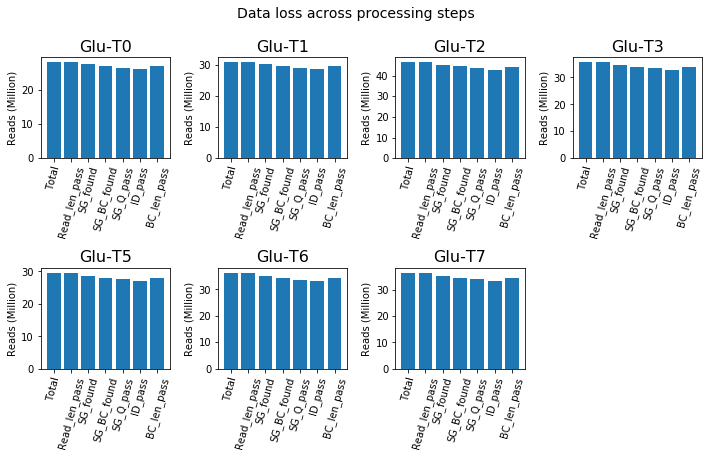

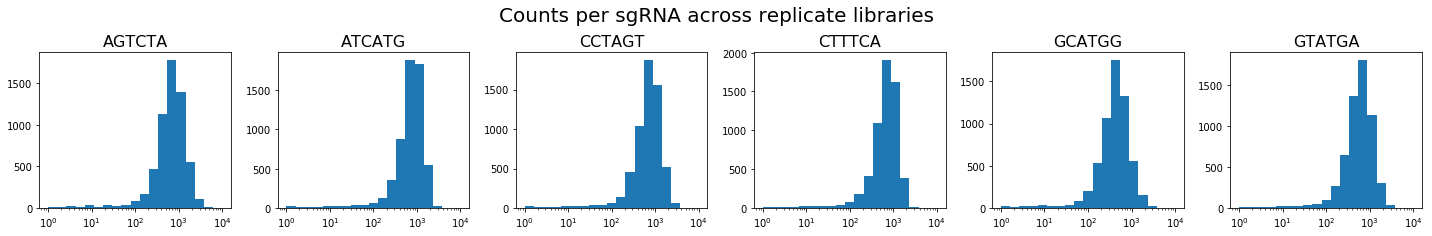

Guides with < 10 counts at T0 (Glu): 
{'ATCATG': 80, 'GCATGG': 99, 'GTATGA': 83, 'AGTCTA': 79, 'CTTTCA': 74, 'CCTAGT': 70}



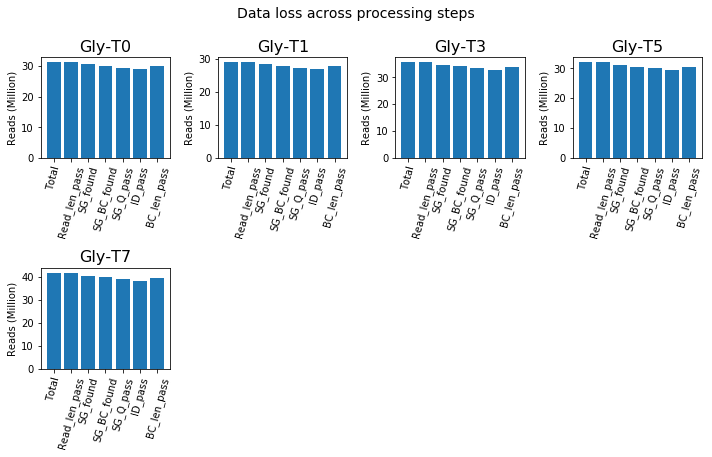

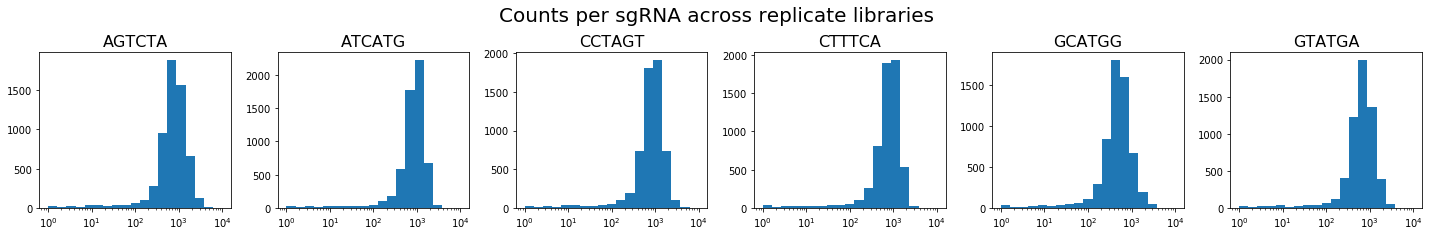

Guides with < 10 counts at T0 (Gly): 
{'ATCATG': 95, 'GCATGG': 117, 'GTATGA': 123, 'AGTCTA': 115, 'CTTTCA': 118, 'CCTAGT': 98}



In [10]:
seq_quality(raw_counts, Count_dict, df_BC, medias)

## Visualize Library Completeness

Imports sequencing data from a MiSeq run on the sgRNA library before transforming it into cells. Creates a heat map of sgRNA abundance in the sample at chosen timepoint. White boxes indicate insufficient counts. White bars across a guide family indicate the respective parent guide was not able to be designed.

In [11]:
# Import library completeness data
with open(miSeq_path, "rb") as input_file:
    miSeq_raw_counts = pickle.load(input_file)

# df_quant and df_quant_dict are only made to run the reorder command properly
df_count_T4 = pd.DataFrame.from_dict(miSeq_raw_counts['T4']['Count_Dict'])
df_count_T4 = df_count_T4.drop('undet', axis=1)
df_count_T4 = df_count_T4.drop(1, axis=0)
df_T4 = df_count_T4.div(df_count_T4.loc['negC_none_10'])
df_quant = np.log2(df_T4)
for col in sort_by:
    df_quant[col] = np.zeros(len(df_quant.index))
df_quant_dict = {}
df_quant_dict['Library'] = df_quant

# df_count_Lib contains sequencing data from a library completeness check
# The dictionary formatting is to allow for previously used commands to read out the data
df_count_Lib = pd.DataFrame.from_dict(miSeq_raw_counts['T-Lib']['Count_Dict'])
df_count_Lib = df_count_Lib.drop('undet', axis=1)
df_count_Lib = df_count_Lib.drop(1, axis=0)
df_count_Lib_dict = {}
df_count_Lib_dict['Library'] = {}
df_count_Lib_dict['Library']['Library-TLib'] = df_count_Lib

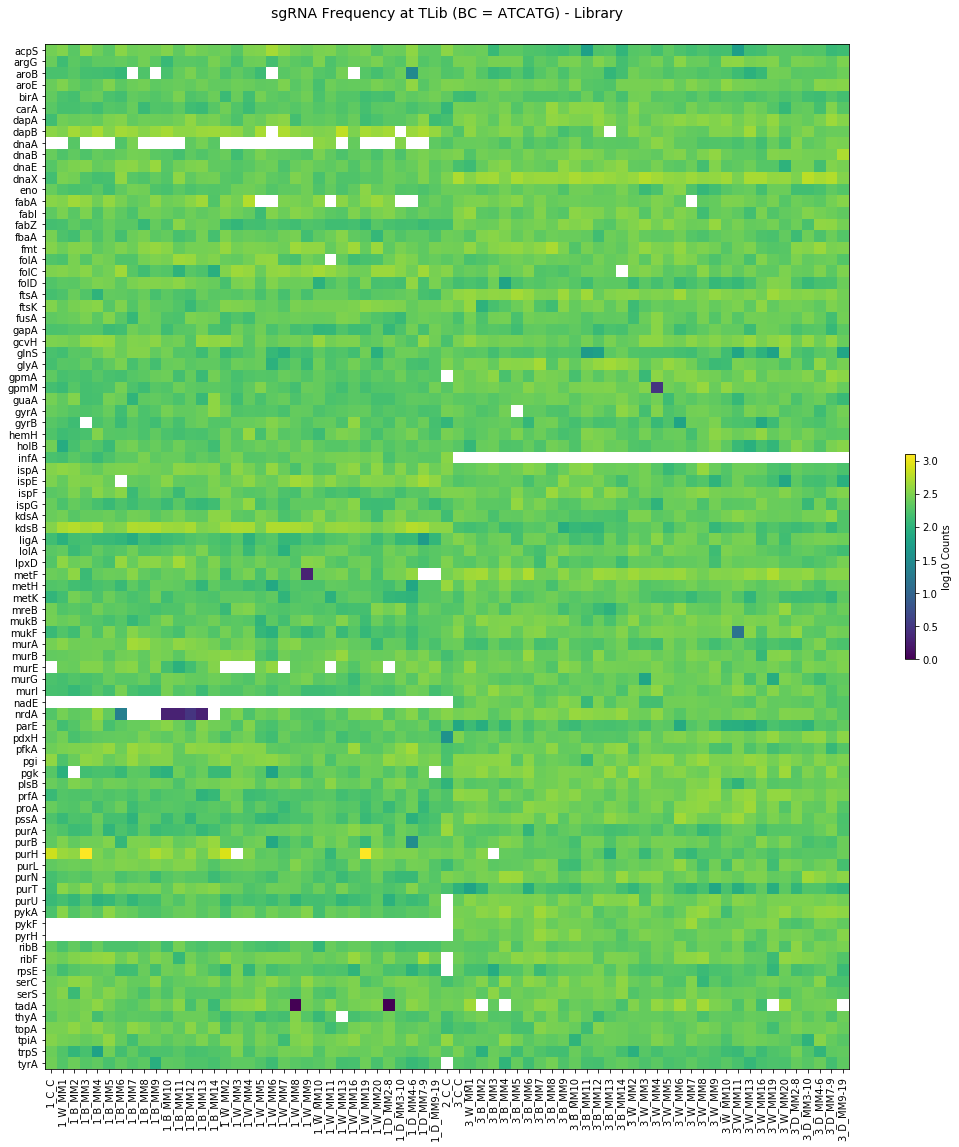

In [12]:
# Figure S3
# Need only count information from reorder
trash, df_miSeq_counts = reorder(df_quant_dict, df_count_Lib_dict, BC_lib, sort_by, new_cols, ['Library'], 'Lib', 2)
# Plot sgRNA frequencies 
frequency_check(df_miSeq_counts, ['Library'], 'Lib', 2)

## Calculate relative frequencies from count data

Match counts to sgRNAs and normalizes counts.

Relative frequency = (Raw counts / negC_rand_42 counts) / (Raw counts T0 / negC_rand_42 counts T0)

In [13]:
df_normed = calc_rel_freq(df_BC, medias)
# Save output
for media in medias:
    with open(pickle_path + date + '_df_normed_' + media.lower() + '.pickle', 'wb') as handle:
        pickle.dump(df_normed[media], handle, protocol=pickle.HIGHEST_PROTOCOL) # Stores for next notebook

## Growth Rate Fitting

Takes normalized count data for each guide across multiple time points. If enough counts (>= 10) are present at enough timepoints (>= 3), fits a linear relationship between relative frequency and time to calculate growth rate relative to negC. If a gene is specified in calc_rel_GR, will plot linear fits for all guides targeting this gene in one replicate. Outputs growth rate data as well as R2 goodness-of-fit data. R2 cutoff set at 0.7 (vertical red line) for successful fitting in downstream analysis.

Mean R2 Glu: 0.8879427915269251


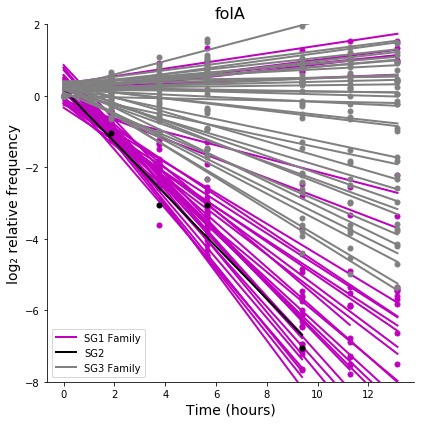

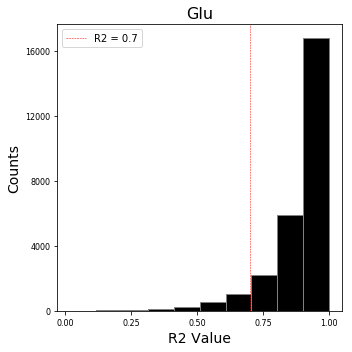

Mean R2 Gly: 0.7923861318025891


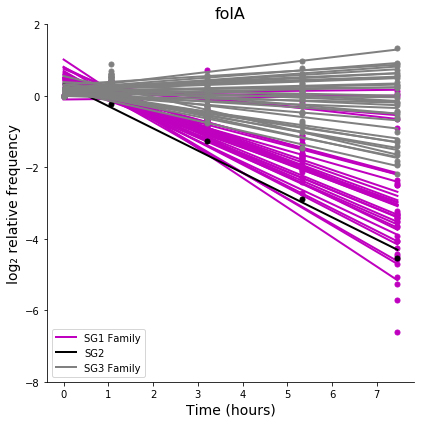

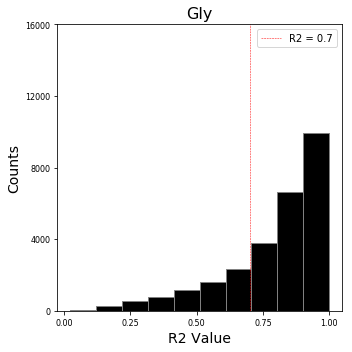

In [14]:
growth_dict, r2_list = calc_rel_GR(df_BC, df_normed, BC_lib, new_cols, medias, TPs, turb_lib, turb_path, 'folA', 1)
# Export R2 list
for media in medias:
    df_r2 = pd.DataFrame(r2_list[media])
    df_r2.to_csv(output_path + date + '_R2_fits_' + media + '.csv')

## Escaper Filtering

Identifies and filters out escapers: sgRNAs where one replicate had a much higher relative frequency than the others. This indicates that a strain may have mutated to "escape" the sgRNA growth defect. Creates a new data frame to hold escaper-corrected growth rate data for sgRNAs with data from at least 3 replicates. Prints filtering statistics, plots an example of successful filtering, and visualizes data quality before and after filtering.

In our data, escapers are problematic in a small fraction (< 1%) of guides. In addition, 95% of guides were found in at least three replicates in M9-Glucose data and 89% of guides were found in at least three replicates in M9-Glycerol data.

/Users/kimreynol/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/kimreynol/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kimreynol/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


Glu:
Total barcoded guides found before filtering: 32826
Fraction of barcoded guides found before filtering: 0.916
Total barcoded guides after escaper correction: 32506
Fraction of barcoded guides after escaper correction:0.907
Total guides with >= 3 replicates after escaper correction: 5698
Fraction of guides with >= 3 replicates after escaper correction: 0.95


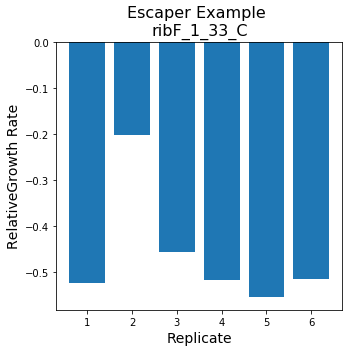

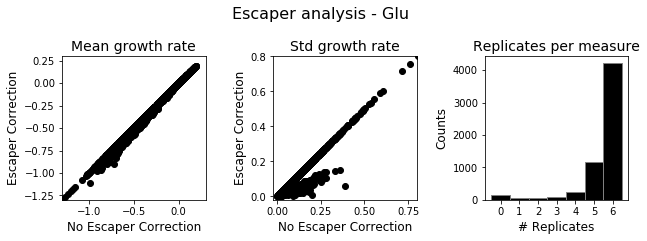

Gly:
Total barcoded guides found before filtering: 27852
Fraction of barcoded guides found before filtering: 0.777
Total barcoded guides after escaper correction: 27582
Fraction of barcoded guides after escaper correction:0.769
Total guides with >= 3 replicates after escaper correction: 5294
Fraction of guides with >= 3 replicates after escaper correction: 0.89


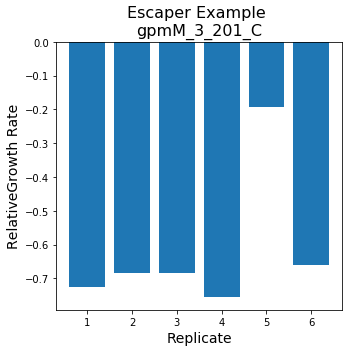

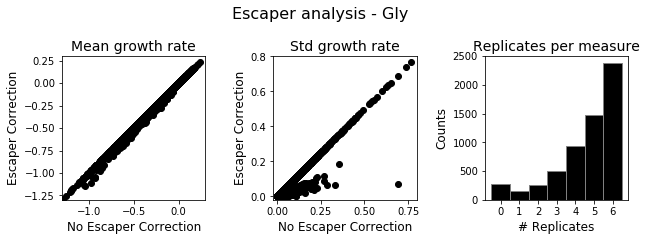

In [15]:
df_growth, df_growth_filt = filter_escapers(growth_dict, sgRNA2seq, escaper_dict, medias, figure_path, date)
# Save growth rate dataframes
for media in medias:
    df_growth[media].to_csv(output_path + date + '_df_growth_' + media + '.csv')
    df_growth_filt[media].to_csv(output_path + date + '_df_growth_filt_' + media + '.csv')

## Reorganize data frames

Reorders growth rate data into gene x sgRNA matrices for downstream analysis.

In [16]:
# Timepoint and replicate don't matter in this block as count data isn't required here
reorder_dict, trash = reorder(df_growth_filt, Count_dict, BC_lib, sort_by, new_cols, medias, 0, 1)

# Save reordered data as .csv
for media in medias:
    reorder_dict[media]['mean'].to_csv(output_path + date + '_df_reorder_' + media + '.csv')
    reorder_dict[media]['sem'].to_csv(output_path + date + '_df_reorder_err_' + media + '.csv')
    reorder_dict[media]['std'].to_csv(output_path + date + '_df_reorder_std_' + media + '.csv')
    reorder_dict[media]['reps'].to_csv(output_path + date + '_df_reorder_N_' + media + '.csv')

## Visualizing Growth Distribution

negC guides are normally distributed, and the Reference strain 'negC_rand_42' lies at the center of the distribution.
Cell death control (death_norm, 'gyrB_2_101_C') has an extreme growth defect.

Relative growth rates are distributed between the cell death and negC strains.

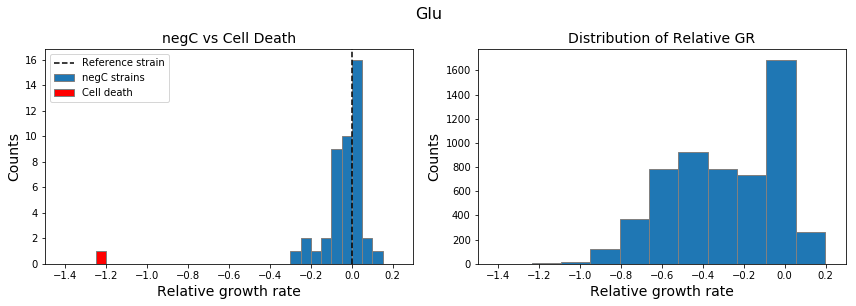

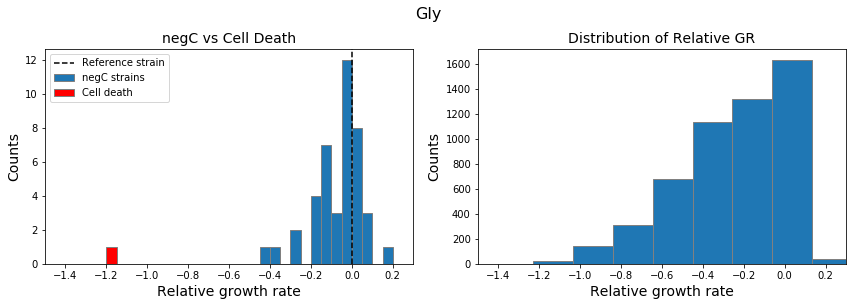

In [17]:
negC_sgRNAs, negC_index = negC_dist(df_growth, medias)

GR_mean = {}
GR_std = {}
for media in medias:
    plt.figure(figsize=(12, 4))
    bins = np.arange(-1.5, 0.25, 0.05)
    plt.subplot(121)
    plt.axvline(df_growth_filt[media]['mean'].loc['negC_rand_42'], label='Reference strain', color='k', ls='--')
    plt.hist(negC_sgRNAs[media], label='negC strains', bins=bins, ec='gray')
    plt.hist(df_growth_filt[media]['mean'].loc[death_norm], label='Cell death', bins=bins, ec='gray', color='r')
    plt.xlim(-1.5, 0.3)
    
    plt.legend()
    plt.title('negC vs Cell Death', fontsize=14)
    plt.xlabel('Relative growth rate', fontsize=14)
    plt.ylabel('Counts', fontsize=14)

    mask = ~np.isnan(df_growth_filt[media]['mean']) & ~np.isnan(df_growth_filt[media]['std'])
    GR_mean[media] = df_growth_filt[media]['mean'][mask]
    GR_std[media] = df_growth_filt[media]['std'][mask]

    plt.subplot(122)
    plt.hist(GR_mean[media], ec='gray')
    plt.title('Distribution of Relative GR', fontsize=14)
    plt.xlabel('Relative growth rate', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.xlim(-1.5, 0.3)
    plt.suptitle(media, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

##  Visualizing Growth Rate Error

Plots a growth rate vs standard deviation heat map to check for systematic error. Also shows a histogram of standard deviation, which should have the majority of guides near 0.

Standard deviation between replicates is low in our data. Variation increases as relative growth rate decreases, potentially due to a larger signal-to-noise ratio when counts are low.

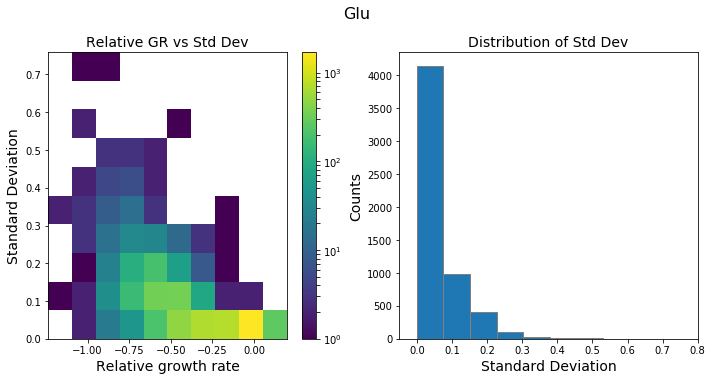

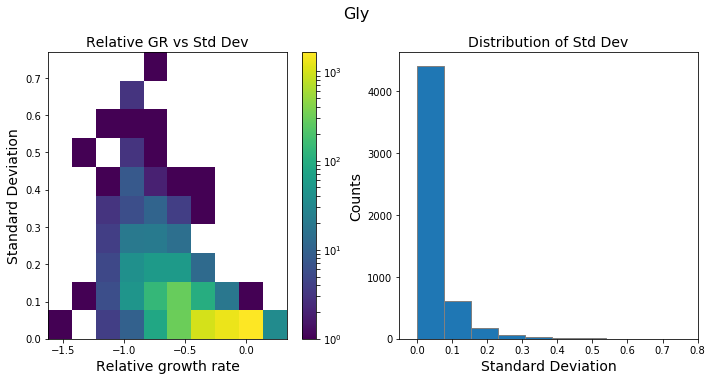

In [18]:
for media in medias:
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.hist2d(GR_mean[media], GR_std[media], norm=mpl.colors.LogNorm())
    plt.colorbar()
    plt.title('Relative GR vs Std Dev', fontsize=14)
    plt.xlabel('Relative growth rate', fontsize=14)
    plt.ylabel('Standard Deviation', fontsize=14)
    plt.tight_layout()

    
    plt.subplot(122)
    plt.hist(GR_std[media], ec='gray')
    plt.title('Distribution of Std Dev', fontsize=14)
    plt.xlabel('Standard Deviation', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.xlim(-0.05, 0.8)
    plt.suptitle(media, y=1.05, fontsize=16)
    plt.tight_layout()
    plt.show()

## Between Replicate Correlations

Replicates are well-correlated (R2 ~ 0.8). Correlation becomes less consistent as relative growth rate decreases, likely an effect of greater standard deviations in this region.

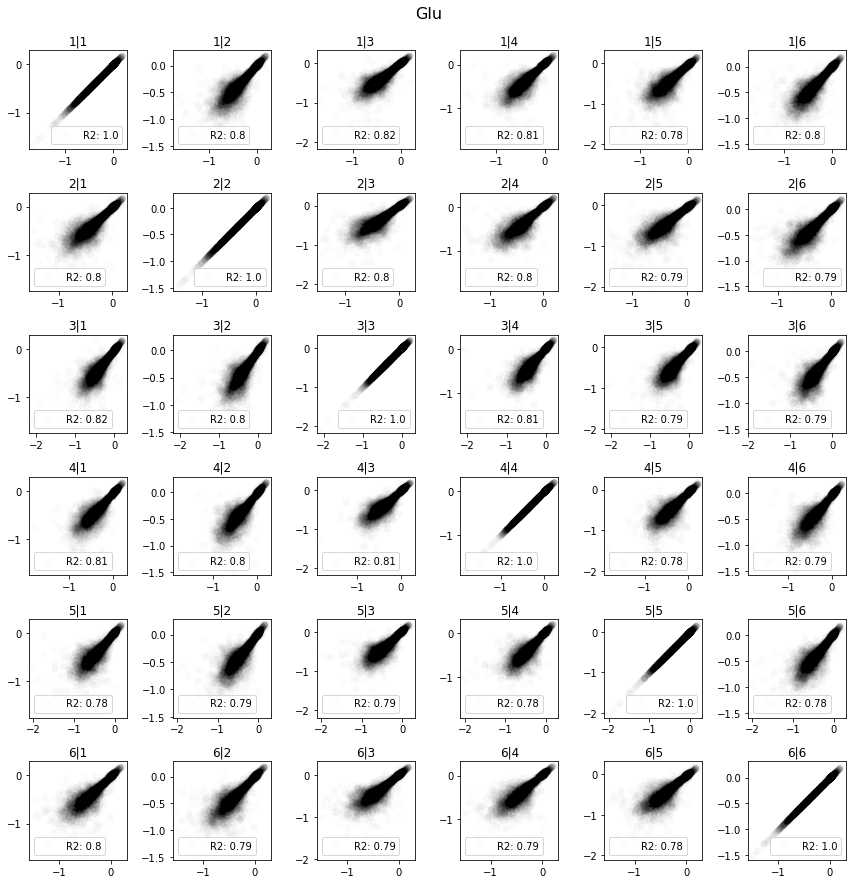

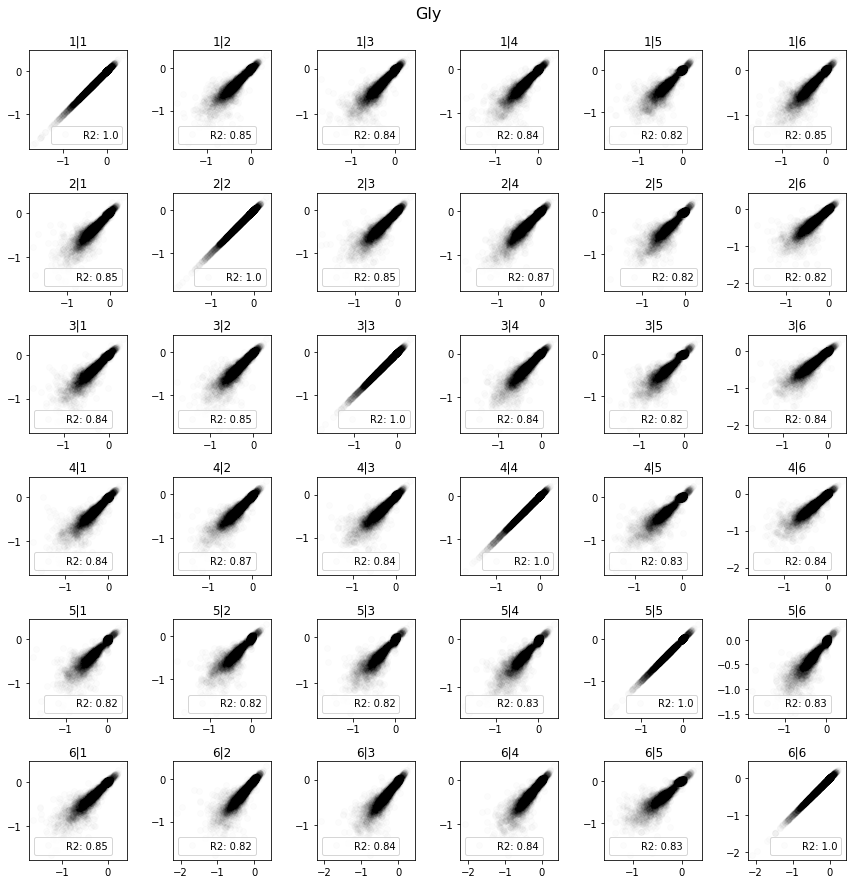

In [19]:
for media in medias:
    fig, ax = plt.subplots(6, 6, figsize=(12, 12))
    for row, repA in enumerate(df_growth[media].columns[0:6]):
        for col, repB in enumerate(df_growth[media].columns[0:6]):
            ax[row][col].set_title(str(row + 1) + '|' + str(col + 1))
            x = df_growth[media][repA]
            y = df_growth[media][repB]
            mask = ~np.isnan(x) & ~np.isnan(y)
            m, b, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
            r2 = round(r_value**2, 2)
            ax[row][col].plot(x, y, 'ok', alpha=0.01, label='R2: ' + str(r2))
            ax[row][col].legend()
    plt.suptitle(media, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    if len(medias) == 2: # Spacer between media plots
        print('\n')

## Calculate Growth Effect 

Growth effect is normalized so cell death = 0 and negC = 1. Outputs this information for downstream analysis.

In [20]:
# Import gene characteristcs like chromsomal location, function, etc.
df_design = pd.read_csv(design_path, index_col=0, parse_dates=True)
df_design.sort_index(inplace=True)

# Initialize dictionaries
df_growth_effect = {}
df_growth_effect_sem = {}
df_growth_effect_std = {}

df_growth_effect_sev = {}
df_growth_effect_sev_std = {}

for media in medias:
    # Calculate CRISPRi relative acitivty to a cell death control (among the most dead with relatively low error)
    df_growth_effect[media] = reorder_dict[media]['mean'].add(abs(df_growth[media].loc[death_norm]['mean-cor']))
    df_growth_effect[media] = df_growth_effect[media].div(abs(df_growth[media].loc[death_norm]['mean-cor']))

    # Filter for only genes that have severe growth defects in M9
    df_growth_effect_sev[media] = df_growth_effect[media][df_design['MOPS_24hr'] < 0.05]

    df_growth_effect_sem[media] = reorder_dict[media]['sem'].div(abs(df_growth[media].loc[death_norm]['mean-cor']))
    df_growth_effect_std[media] = reorder_dict[media]['std'].div(abs(df_growth[media].loc[death_norm]['mean-cor']))
    df_growth_effect_sev_std[media] = df_growth_effect_std[media][df_design['MOPS_24hr'] < 0.05]

    # Save files to .csv
    df_growth_effect[media].to_csv(output_path + date + '_df_growth_effect_' + media + '.csv')
    df_growth_effect_sem[media].to_csv(output_path + date + '_df_growth_effect_sem_' + media + '.csv')
    df_growth_effect_std[media].to_csv(output_path + date + '_df_growth_effect_std_' + media + '.csv')
    df_growth_effect_sev[media].to_csv(output_path + date + '_df_growth_effect_severe_' + media + '.csv')
    df_growth_effect_sev_std[media].to_csv(output_path + date + '_df_growth_effect_severe_std_' + media + '.csv')
     

In [21]:
# Initialize dictionary
reorder_singles_dict = {}
df_singles_dict = {}
for media in medias:
    df_singles = df_growth[media].T[0:6].T # Take growth rate from each single timepoint
    for guide in df_singles.index: 
        # Remove escapers
        if str(df_growth[media]['escaper-IDX'].loc[guide]) != 'nan':
            idx = df_singles.columns[df_growth[media]['escaper-IDX'].loc[guide]]
            df_singles[idx].loc[guide] = np.nan
    df_singles_dict[media] = df_singles
    
reorder_singles_dict, trash = reorder(df_singles_dict, Count_dict, BC_lib, 
                                             df_singles.columns, new_cols, medias, 0, 1)
for media in medias:
    for key in reorder_singles_dict[media].keys(): # For all replicates
        df_norm = reorder_singles_dict[media][key].add(abs(df_growth[media].loc[death_norm]['mean-cor']))
        df_norm = df_norm.div(abs(df_growth[media].loc[death_norm]['mean-cor']))
        reorder_singles_dict[media][key] = df_norm

for media in medias:
    # Export as a pickle
    with open(pickle_path + date + '_df_single_eff_' + media.lower() + '.pickle', 'wb') as handle:
        pickle.dump(reorder_singles_dict[media], handle, protocol=pickle.HIGHEST_PROTOCOL) # Stores for next notebook

## Make supplemental files

In [22]:
# Organize sgRNA library data and output to a file
# Table S1
df_sgRNA2seq = pd.DataFrame.from_dict(sgRNA2seq, orient='index')
# Name column and alphabetize index
df_sgRNA2seq.columns = ['sgRNA homology region']
df_sgRNA2seq = df_sgRNA2seq.sort_index()
# Rename mismatch types to be more intuitive
mismatch_names = {'B':'Comp', 'W':'Single', 'D':'Double', 'C':'Parent'}

ID_list = []
for guide in df_sgRNA2seq.index:
    sp = guide.split('_')
    if 'negC' not in sp and 'purE' not in sp: # These genes have different formatting
        sp[3] = mismatch_names[sp[3]] # Update mismatch type
        try: # Parent sgRNAs do not have an index at position 4
            MM = sp[4] # Number or location of mismatches
            loc = MM.split('MM')[-1] # Convert this into a number
            if '-' in loc: # Double mismatch formatting
                M1, M2 = loc.split('-') # Extract double mismatch scales
                M1_n = str(int(M1)-21) # Organize mismatch location to be consistent with paper discussion
                M2_n = str(int(M2)-21)
                sp[4] = M1_n + '|' + M2_n
            elif sp[3] == 'Comp': # Compounding mismatches
                sp[4] = "-20 to " + str(int(loc)-21)
            else: # Single mismatches
                sp[4] = int(loc) - 21
            ID_list.append(sp)
        except: # Captures parent sgRNAs that don't have mismatches
            ID_list.append(sp)
    elif 'negC' in sp: # Oranizes negC sgRNAs
        sp2 = [sp[0], 'N/A', 'N/A', 'negC_' + sp[1] + sp[2], 'None']
        ID_list.append(sp2)
    else: # Same organization for purE sgRNAs
        sp2 = [sp[0], sp[1], sp[2], 'Org. Cell Death rep:' + sp[3], 'None']
        ID_list.append(sp2)

# Combine data and export
df_list = pd.DataFrame(ID_list)
df_list.index = df_sgRNA2seq.index
df_list['sgRNA homology region'] = df_sgRNA2seq['sgRNA homology region']
df_list.columns = ['Gene', 'SG #', 'PAM loc.', 'Mut. type', 'Mut. loc.', 'H.R. seq']
df_list.to_csv(table_path + date + '_sgRNA_Library_TableS1.csv')

In [23]:
# Table S3
# Creating Excel Writer Object from Pandas
writer = pd.ExcelWriter(table_path + date + '_glu_counts_TableS3.xlsx', engine='xlsxwriter')
workbook = writer.book
for BC in BC_lib:
    worksheet = workbook.add_worksheet(BC)
    writer.sheets[BC] = worksheet
    df_BC['Glu'][BC].to_excel(writer, sheet_name=BC, startrow=0, startcol=0)
writer.save()

# Table S4
# Creating Excel Writer Object from Pandas
writer = pd.ExcelWriter(table_path + date + '_gly_counts_TableS4.xlsx', engine='xlsxwriter')
workbook = writer.book
for BC in BC_lib:
    worksheet = workbook.add_worksheet(BC)
    writer.sheets[BC] = worksheet
    df_BC['Gly'][BC].to_excel(writer, sheet_name=BC, startrow=0, startcol=0)
writer.save()

In [24]:
# Table S5 and Table S6
death_glu = df_growth_filt['Glu']['mean'].loc[death_norm]
df_growth_filt['Glu']['norm.GR'] = (df_growth_filt['Glu']['mean']+abs(death_glu)) / abs(death_glu)
df_growth_filt['Glu']['norm.GR_sem'] = df_growth_filt['Glu']['sem'] / abs(death_glu)

death_gly = df_growth_filt['Gly']['mean'].loc[death_norm]
df_growth_filt['Gly']['norm.GR'] = (df_growth_filt['Gly']['mean']+abs(death_gly)) / abs(death_gly)
df_growth_filt['Gly']['norm.GR_sem'] = df_growth_filt['Gly']['sem'] / abs(death_gly)

df_growth_filt['Glu'].to_csv(table_path + date + '_glu_growth_rates_TableS5.csv')
df_growth_filt['Gly'].to_csv(table_path + date + '_gly_growth_rates_TableS6.csv')

In [25]:
# Total number of titrating/on target sgRNAs in library
count = 0
for i, index in enumerate(df_list.index):
    if 'negC' not in index and 'purE' not in index:
        count += 1
print(str(count) + ' total sgRNAs in the library that titrate gene expression')

5927 total sgRNAs in the library that titrate gene expression
